In [ ]:
# Import PyDrive and associated libraries
# This only needs to be done once per notebook
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
# This only needs to be done once per notebook
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


file_id = '1SZ-hYkI8UgrfJlgwRWlNLHHHurqUj3Lh' # Check your own ID in GDrive
downloaded = drive.CreateFile({'id': file_id})

# Save file in Colab memory
downloaded.GetContentFile('tweets.csv')  

In [ ]:
pip install contractions emoji

     |████████████████████████████████| 168 kB 8.4 MB/s 
     |████████████████████████████████| 321 kB 43.4 MB/s 
     |████████████████████████████████| 284 kB 62.1 MB/s 
  Created wheel for emoji: filename=emoji-1.6.0-py3-none-any.whl size=168256 sha256=c4c169925bc219f171f4e705ea3ae8e928bb8eb025ef2babfac0db44feda4cf3
  Stored in directory: /root/.cache/pip/wheels/f7/d7/74/c720aaf345a042b0c2d74361873258c5e8649b7f11b2ccce49
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85454 sha256=38aa7b3933db27e4cf6de0363198219adb8ab05f8aabb9c07a2f18ad7f8332a8
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built emoji pyahocorasick


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
import re,nltk,contractions,emoji 
sns.set_style('dark')
from wordcloud import WordCloud
from textblob import TextBlob

In [ ]:
def clean_date(date_obj):
  for x in range(0, len(date_obj)):
    if date_obj[x] == " ":
      break
  date_obj = date_obj[:x]
  return date_obj

def process_tweet(tweet):
  ## Twitter Features
    # replace retweet
  tweet = re.sub('RT\s+', "", tweet )
    # replace user tag
  tweet = re.sub('\B@\w+', "", tweet)
    # replace url
  tweet = re.sub('(http|https):\/\/\S+', "", tweet)
    # replace hashtag
  tweet = re.sub('#+', "", tweet)

  ## Word Features
    # lower case
  tweet = tweet.lower()
    # replace contractions
  tweet = contractions.fix(tweet)
    # replace punctuation repetition
  tweet = re.sub(r'[\?\.\!]+(?=[\?\.\!])', "", tweet)
    # replace word repetition
  tweet = re.sub(r'(.)\1+', r'\1\1', tweet)
    # replace emojis
  tweet = emoji.demojize(tweet)

  return tweet

df = pd.read_csv('tweets.csv',
                 lineterminator='\n')
df = df[df["Language\r"]=="en\r"].drop(['Unnamed: 0', 'Tweet Id', 'Language\r'],axis=1)
df["Datetime"] = df["Datetime"].apply(clean_date)
df["Clean Text"] = df["Text"].apply(process_tweet)
df['Clean Text']= df['Clean Text'].str.replace('[^\w\s]','')


In [ ]:
# Performing VADER Sentiment Analysis
import nltk
nltk.download('vader_lexicon') # Download the VADER lexicon
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Obtaining NLTK scores
df['VScore'] = df['Clean Text'].apply(lambda x: sia.polarity_scores(x))

# Obtaining NLTK compound score
df['VComp'] = df['VScore'].apply(lambda score_dict: score_dict['compound'])

# Set threshold to define neutral sentiment
neutral_thresh = 0.05

# Categorize scores into the sentiments of positive, neutral or negative
df['Sentiment'] = df['VComp'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
import networkx as nx
import itertools, collections
from nltk import bigrams
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
new_stopwords_to_add = ['covid19', 'covid','vaccine', 'covid-19', '19', 'vaccines', 'vaccine.','vaccine?', '-', '.']
stop_words.extend(new_stopwords_to_add)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Check d[0].items() for understanding more about graph plot

def BigramsAnalysis(sentiment):
  l_words = df[df["Sentiment"]==sentiment]["Clean Text"].tolist()
  words_in_tweet = [tweet.split() for tweet in l_words]
  words_lemmatized = [[word for word in tweet_words]
              for tweet_words in words_in_tweet]
  tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_lemmatized]
  terms_bigram = [list(bigrams(tweet)) for tweet in tweets_nsw if tweet]
  bigrams_list = list(itertools.chain(*terms_bigram))
  bigram_counts = collections.Counter(bigrams_list)
  bigram_df = pd.DataFrame(bigram_counts.most_common(50),
                             columns=['bigram', 'count'])
  d = bigram_df.set_index('bigram').T.to_dict('records')
  G = nx.Graph()
  for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v))
  fig, ax = plt.subplots(figsize=(14, 10))

  pos = nx.spring_layout(G, k=2)

  # Plot networks
  nx.draw_networkx(G, pos,
                  font_size=16,
                  width=3,
                  edge_color='grey',
                  node_color='purple',
                  with_labels = False,
                  ax=ax)

  # Create offset labels
  for key, value in pos.items():
      x, y = value[0]+.100, value[1]+.025
      ax.text(x, y,
              s=key,
              bbox=dict(facecolor='red', alpha=0.15),
              horizontalalignment='center', fontsize=13)
      
  plt.show()
  return bigram_df

def Search(keywords, is_df=False):
  pd.set_option('display.max_colwidth', 400)
  if not is_df:
    result = df[df["Clean Text"].str.contains(keywords)]["Text"]
  else:
    result = df[df["Clean Text"].str.contains(keywords)].sort_values(by='Datetime')
  return result

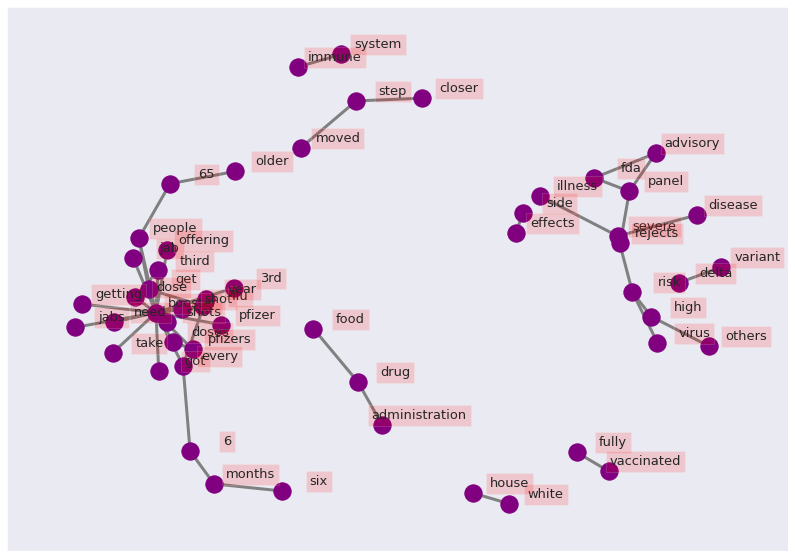

In [ ]:
input_ = 'Negative'
neg = BigramsAnalysis(input_)

In [ ]:
neg

,bigram,count
0,"(booster, shots)",5620
1,"(booster, shot)",3044
2,"(get, booster)",1888
3,"(need, booster)",1305
4,"(high, risk)",1222
5,"(flu, shot)",1078
6,"(booster, dose)",909
7,"(booster, doses)",787
8,"(pfizer, booster)",751
9,"(6, months)",737


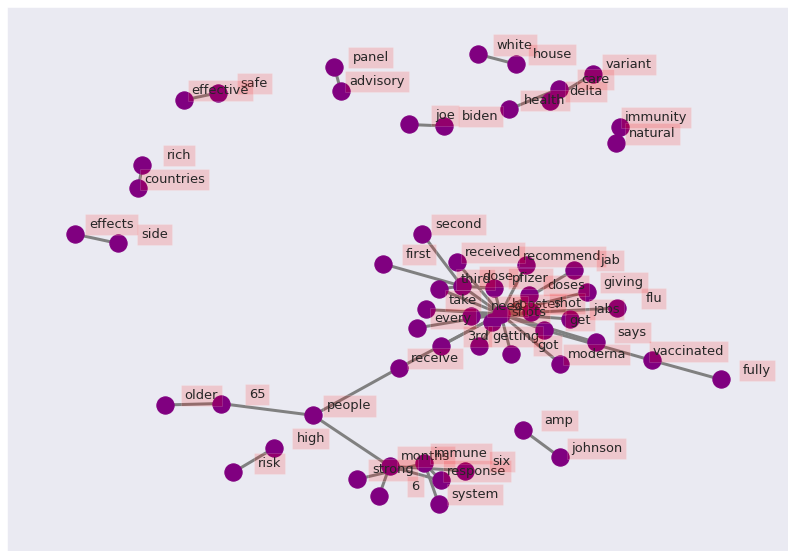

In [ ]:
input_ = 'Positive'
pos = BigramsAnalysis(input_)

In [ ]:
pos

,bigram,count
0,"(booster, shots)",7121
1,"(booster, shot)",5019
2,"(get, booster)",2723
3,"(booster, dose)",1839
4,"(need, booster)",1706
5,"(booster, doses)",1238
6,"(pfizer, booster)",1120
7,"(6, months)",1034
8,"(natural, immunity)",783
9,"(getting, booster)",726


In [ ]:
Search("strong immune")

7571     @JimeeLiberty @SultaneAlexand1 @andylumm @scotty_nice @InCytometry @Tony__Heller @SkepticalMutant @luke_rakoczy @doom37455413 @IainMulady @Shared_facts @TheFreeScot @michaelbranniga @MichaelBuerger8 @richykirsh @Covid19isALie @alexisleclezio @MsTrixter @provaxtexan @zeetubes @AndrewLazarus4 @mcfunny @MichaelYeadon3 @ConsequentialBr @duderdude2009 @Monstercoyliar @SeriousSkeptic @Kathmarval @j0...
8283                                                                                                                                                                                                                                                                      Covid BOOSTER DOSE\nWhy Covid-19 Booster Shot vaccine and 3rd Dose Required? \n#strong #immune #system #shot #booster\nhttps://t.co/kf1NK5JwSG
16139                                                                                                                                                                                 

In [ ]:
df1 = Search("natural immunity", is_df=True)
df1[(df1["Datetime"] == '2021-09-10')]

,Datetime,Text,Username,Like Count,Display Name,Clean Text,VScore,VComp,Sentiment
59557,2021-09-10,"@PoliticAlBor Hmmmm the flu kills 60,000 plus a yr for decades, is that vaccine mandated? Nope.. it's should be a choice, also they are already throwing a booster shot on it.. so that really shows it's ineffectiveness. They don't even care if people have a natural immunity. It's b.s.",Bill37166272,0,Bill,hmm the flu kills 6000 plus a yr for decades is that vaccine mandated nope it is should be a choice also they are already throwing a booster shot on it so that really shows it is ineffectiveness they do not even care if people have a natural immunity it is bs,"{'neg': 0.195, 'neu': 0.761, 'pos': 0.044, 'compound': -0.819}",-0.8190,Negative
59437,2021-09-10,@CatLvrMarketing @PhilMckFit @shelbyferrari @APhilosophae Natural immunity wins 700% over vaccines already. This data is from the worlds largest live lab test Israel.\n\nTheyve already had a 3rd booster and theyre still getting sick. Eat crow bro. The vaxx and boosters are are failing. You'll get covid anyways.,Moreforus,1,Moreforus,natural immunity wins 700 over vaccines already this data is from the worlds largest live lab test israel\n\nthey have already had a 3rd booster and they are still getting sick eat crow bro the vaxx and boosters are are failing you will get covid anyways,"{'neg': 0.123, 'neu': 0.762, 'pos': 0.115, 'compound': -0.1027}",-0.1027,Negative
59446,2021-09-10,"@andrewsibley15 @Nigel_Farage You need to read and listen, on LBC today they were discussing the fact that natural immunity lasts longer, are they not reporting now the vaccine needs a booster after 6 months 😂😂",SubseaDC,0,Baron Flange,you need to read and listen on lbc today they were discussing the fact that natural immunity lasts longer are they not reporting now the vaccine needs a booster after 6 months face_with_tears_of_joyface_with_tears_of_joy,"{'neg': 0.0, 'neu': 0.923, 'pos': 0.077, 'compound': 0.3612}",0.3612,Positive
59460,2021-09-10,@Breaking911 We already know natural Immunity lasts longer then the vaccine by far. You wouldn’t need booster shots if the vaccine lasted longer. Natural immunity can last years you can the lord for that.,zamos622,38,UnitedWeStand❤️🇺🇸,we already know natural immunity lasts longer then the vaccine by far you would not need booster shots if the vaccine lasted longer natural immunity can last years you can the lord for that,"{'neg': 0.0, 'neu': 0.865, 'pos': 0.135, 'compound': 0.6124}",0.6124,Positive
59524,2021-09-10,"@EssexPR Natural immunity lasts significantly longer than the vaccine, which is already needing a booster.",ASmallVoice3,9,A Small Voice,natural immunity lasts significantly longer than the vaccine which is already needing a booster,"{'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'compound': 0.3612}",0.3612,Positive
...,...,...,...,...,...,...,...,...,...
60892,2021-09-10,@foresthempen @millennialwoah It’s weird that you trust a rushed vaccine that is starting to show less immunity to these new variants. Like we are the idiots for being hesitant when even WHO doesn’t like the idea of a third booster shot. There is a reason for that… natural immunity is stronger anyway,Jakegsm,22,Jake Gsm News,it is weird that you trust a rushed vaccine that is starting to show less immunity to these new variants like we are the idiots for being hesitant when even who does not like the idea of a third booster shot there is a reason for that natural immunity is stronger anyway,"{'neg': 0.063, 'neu': 0.711, 'pos': 0.227, 'compound': 0.8658}",0.8658,Positive
60210,2021-09-10,Natural immunity 13 times stronger than double vaccinated. 3rd booster is doing well for most vaxxed. That's probably why 1 dose of vaccine ups immunity for previous infected quite high (but goes no higher on 2nd vaccine) https://t.co/ggf3Ou7b3T,SuziSaul,0,SuziSaul,natural immunity 13 times stronger than double vaccinated 3rd booster is doing well for most vaxxed that is probably why 1 dose of vaccine

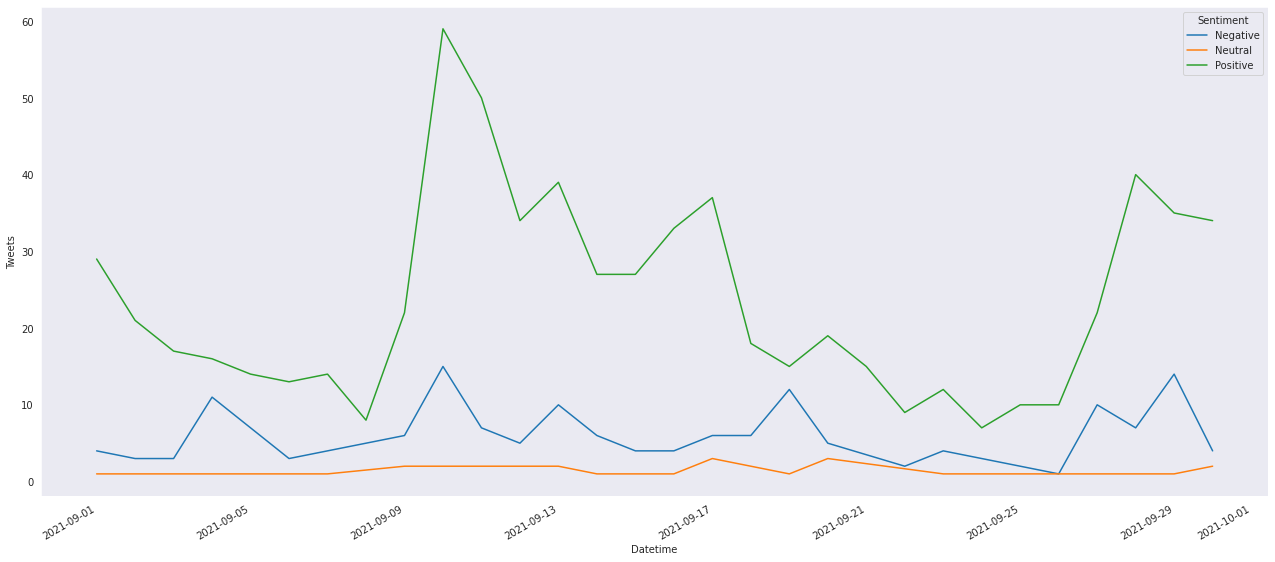

In [ ]:
df1["Datetime"] = pd.to_datetime(df1.Datetime) 
timeline = df1.resample('D', on='Datetime')["Sentiment"].value_counts().unstack(1)
timeline.reset_index(inplace=True)
timeline = timeline.melt("Datetime", var_name='Sentiment',  value_name='Tweets')

plt.figure(figsize=(22,10))
ax = sns.lineplot(x="Datetime", y="Tweets", hue="Sentiment", data=timeline)
ax.figure.autofmt_xdate()